In [1]:
!pip install -q jax jaxlib matplotlib


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt


As a benchmark for real system dynamics, we consider a simple pendulum.

$$
\begin{align*}
  \ddot{\theta} &= -\frac{g}{l} \sin(\theta)
  \ddot{\theta} &= -\frac{g}{l} \sin(\theta)
\end{align*}
$$


In [5]:
def kinetic_energy(theta, theta_dot, m, l):
    return 0.5 * m * (l * theta_dot) ** 2

def potential_energy(theta, m, l, g=9.81):
    return -m * g * l * jnp.cos(theta)

def energy(state, m=1, l=1):
    theta, theta_dot = state
    return kinetic_energy(theta, theta_dot, m, l) + potential_energy(theta, m, l)

This is useful because it's a nonlinear system with oscillatory behavior, helping us verify method stability and the ability to conserve system energy during long simulations.
Also, it is an example of a system that can't be solved analytically. Due to this fact, we also benchmark a pair of simple nonlinear first-order ODEs:

$$
\begin{align*}
  \dot{f}(x) &= \exp(x) \\\\
  f(x) &= \exp(x)
\end{align*}
$$

$$
\begin{align*}
  \dot{g}(x) &= x \cdot \cos(x) \\\\
  g(x) &= x \cdot \sin(x) + \cos(x)
\end{align*}
$$

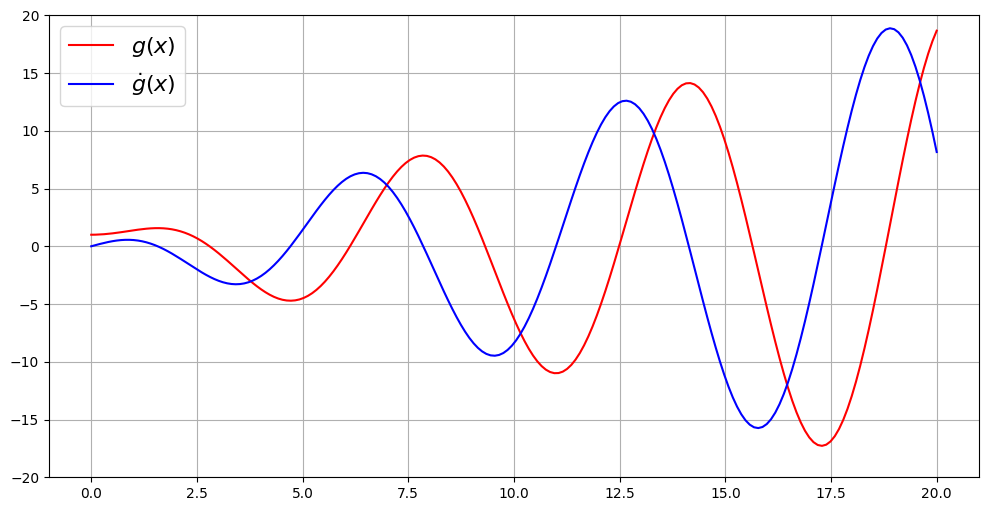

In [3]:
fig = plt.figure(figsize=(12, 6))
x = jnp.linspace(0, 20, 200)

def f(x):
    return jnp.exp(x)

def dot_f(x):
    return jnp.exp(x)

def g(x):
    return x * jnp.sin(x) + jnp.cos(x)

def dot_g(x):
    return x * jnp.cos(x)

ax = fig.add_subplot(111)
ax.plot(x, g(x), c="r", label=r"$g(x)$")
ax.plot(x, dot_g(x), c="b", label=r"$\dot{g}(x)$")
ax.legend(fontsize=16)
ax.set_ylim(-20, 20)
ax.grid()

fig.savefig("example.png")


# Euler's method

$$
\begin{align*}
  y(x + h) &= y(x) + h \cdot \dot{y}(x)
\end{align*}
$$

In [6]:
def euler(dot_f, f, x, h, step_n):
    args, vals = [], []
    for i in range(step_n + 1):
        args.append(x)
        vals.append(f)
        f = f + h * dot_f(x)
        x = x + h

    return jnp.array(args), jnp.array(vals)


figure = plt.figure(figsize=(12, 6))

x, y_hat = euler(dot_f, f(0), 0, 0.1, 30)
error = y_hat - f(x)

energy_history = jax.vmap(energy)(jnp.array(y_hat))

ax = figure.add_subplot(111)
ax.set_title("Euler method")
ax.plot(x, error, c="r", label="f(x) error")
ax.legend(fontsize=16)
plt.grid()

figure.savefig("euler.png")


TypeError: iteration over a 0-d array

<Figure size 1200x600 with 0 Axes>

# Runge-Kutta family

## RK II
$$
\begin{align*}
  k_1 &= h \cdot \dot{y}(x) \\
  k_2 &= h \cdot \dot{y}(x + \frac{h}{2}) \\
  y(x + h) &= y(x) + k_2
\end{align*}
$$

## RK IV
$$
\begin{align*}
  k_1 &= h \cdot \dot{y}(x) \\
  k_2 &= h \cdot \dot{y}(x + \frac{h}{2}) \\
  k_3 &= h \cdot \dot{y}(x + \frac{h}{2}) \\
  k_4 &= h \cdot \dot{y}(x + h) \\
  y(x + h) &= y(x) + \frac{k_1 + 2k_2 + 2k_3 + k_4}{6}
\end{align*}
$$

In [5]:
def rk2(dot_f, f, x, h, step_n):
    args, vals = [], []
    for i in range(step_n + 1):
        args.append(x)
        vals.append(f)
        k1 = dot_f(x)
        k2 = dot_f(x + h)
        f = f + h * (k1 + k2) / 2
        x = x + h

    return jnp.array(args), jnp.array(vals)

# Runge-Kutta IV

$$
\begin{align*}
  k_1 &= h \cdot \dot{y}(x) \\
  k_2 &= h \cdot \dot{y}(x + \frac{h}{2}) \\
  k_3 &= h \cdot \dot{y}(x + \frac{h}{2}) \\
  k_4 &= h \cdot \dot{y}(x + h) \\
  y(x + h) &= y(x) + \frac{k_1 + 2 \cdot k_2 + 2 \cdot k_3 + k_4}{6}
\end{align*}
$$

In [ ]:
def rk_4(dot_f, f, x, h, step_n):
    args, vals = [], []
    for i in range(step_n + 1):
        args.append(x)
        vals.append(f)
        k1 = dot_f(x)
        k2 = dot_f(x + h / 2)
        k3 = dot_f(x + h / 2)
        k4 = dot_f(x + h)
        f = f + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x = x + h

    return jnp.array(args), jnp.array(vals)

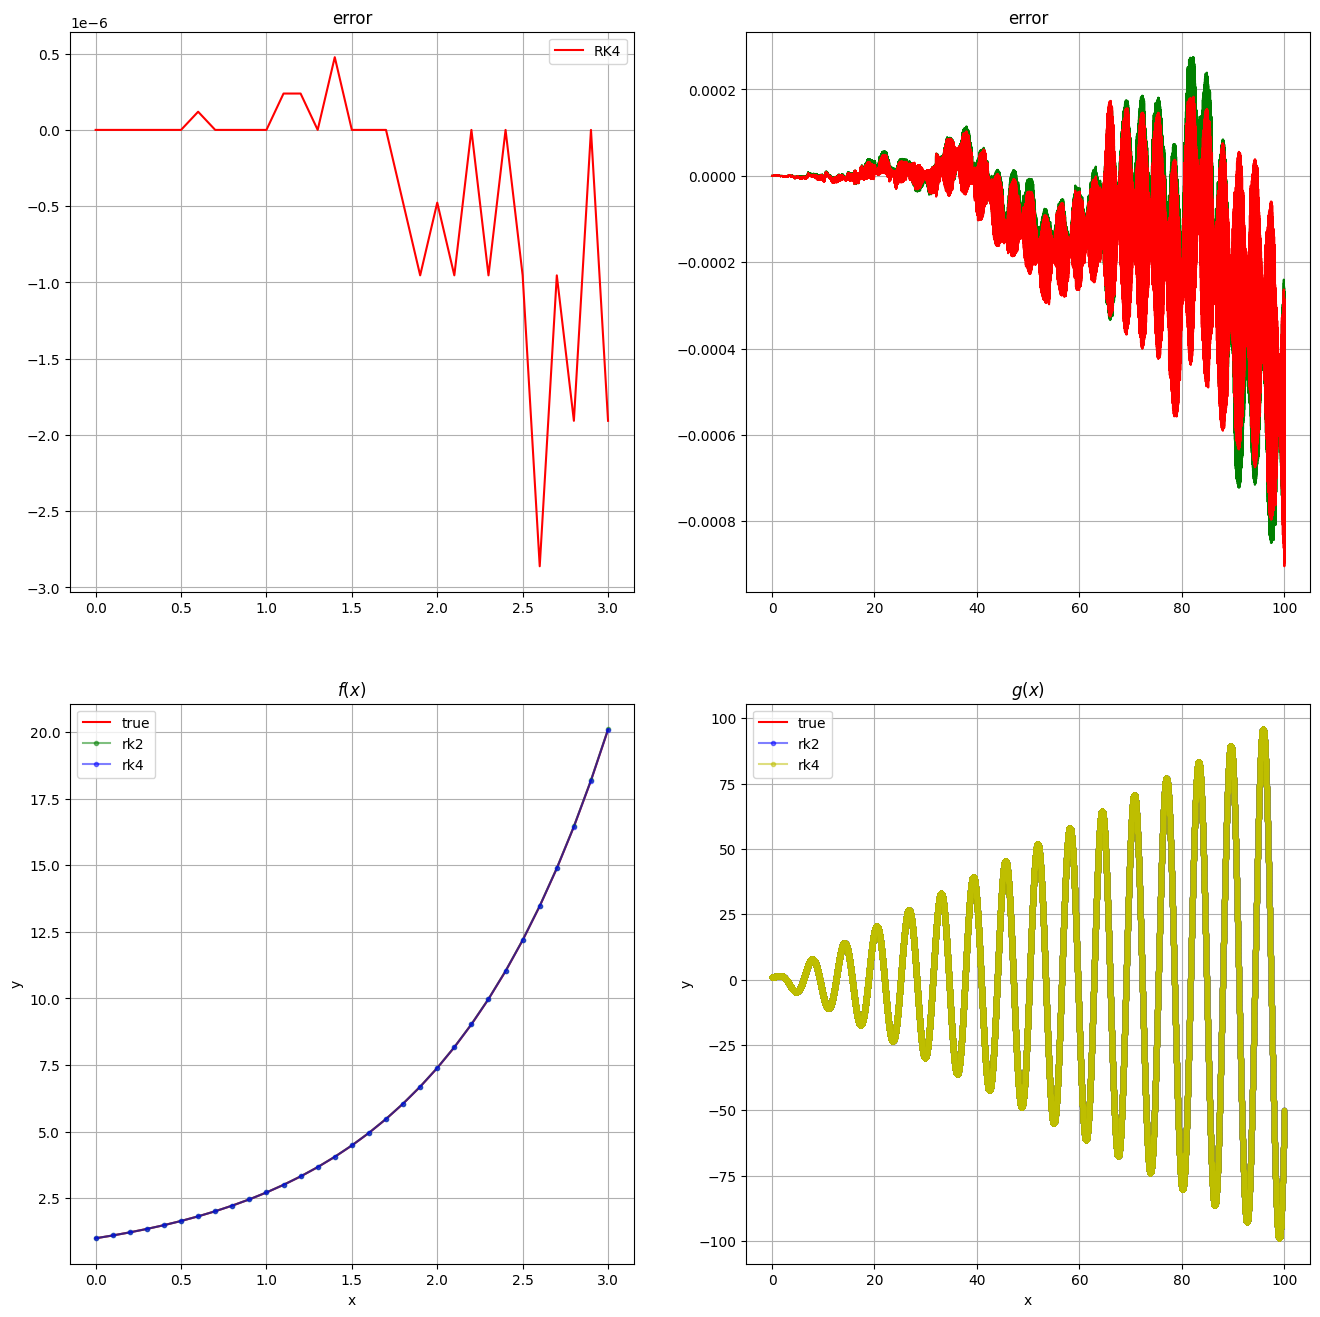

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16), gridspec_kw={"height_ratios": [1, 1]})

x, f_euler = euler(dot_f, f(0), 0, 0.1, 30)
_, f_rk2 = rk2(dot_f, f(0), 0, 0.1, 30)
_, f_rk4 = rk_4(dot_f, f(0), 0, 0.1, 30)
f_true = f(x)

axs[1][0].set_title(r"$f(x)$")
axs[1][0].plot(x, f_true, c="r", label="true")
# axs[1][0].plot(x, f_euler, c="y", label="euler", marker=".", alpha=0.5)
axs[1][0].plot(x, f_rk2, c="g", label="rk2", marker=".", alpha=0.5)
axs[1][0].plot(x, f_rk4, c="b", label="rk4", marker=".", alpha=0.5)
axs[1][0].set_xlabel("x")
axs[1][0].set_ylabel("y")
axs[1][0].legend()
axs[1][0].grid()

axs[0][0].set_title(r"error")
# axs[0][0].plot(x, f_true - f_euler, c="b", label="euler")
# axs[0][0].plot(x, f_true - f_rk2, c="g", label="RK2")
axs[0][0].plot(x, f_true - f_rk4, c="r", label="RK4")
axs[0][0].legend()
axs[0][0].grid()


N = 100000
x, g_euler = euler(dot_g, g(0), 0, 0.001, N)
_, g_rk2 = rk2(dot_g, g(0), 0, 0.001, N)
_, g_rk4 = rk_4(dot_g, g(0), 0, 0.001, N)
g_true = g(x)

axs[1][1].set_title(r"$g(x)$")
axs[1][1].plot(x, g_true, c="r", label="true")
# axs[1][1].plot(x, g_euler, c="g", label="euler", marker=".", alpha=0.5)
axs[1][1].plot(x, g_rk2, c="b", label="rk2", marker=".", alpha=0.5)
axs[1][1].plot(x, g_rk4, c="y", label="rk4", marker=".", alpha=0.5)
axs[1][1].set_xlabel("x")
axs[1][1].set_ylabel("y")
axs[1][1].legend()
axs[1][1].grid()

axs[0][1].set_title(r"error")
# axs[0][1].plot(x, g_true - g_euler, c="b", label="euler")
axs[0][1].plot(x, g_true - g_rk2, c="g", label="RK2")
axs[0][1].plot(x, g_true - g_rk4, c="r", label="RK4")
axs[0][1].grid()

Use cart-pole dynamic model as benchmark for comparision of numerical integration methods:

$$
\begin{equation*}
    \ddot{\theta} = -\frac{\mu}{\left(m_p l^2 + I_p\right)}\dot{\theta}
            - \frac{\ddot{x} \cos \theta - g \sin \theta}{l + \frac{I_p}{m_p l}}.
\end{equation*}
$$

- $x$ – cart position
- $\theta$ – pole angle
- $\mu$ – friction coefficient
- $m_p$ – mass of the pole
- $l$ – distance for joint to the center of mass of the pole
- $I_p$ – moment of inertia of the pole
- $g$ – gravity constant
- $\ddot{x} = a$ – acceleration of the cart (control input)


In [5]:
class CartPole:
  def __init__(self, m_p=0.1, l=0.3, I_p=0.006, mu=0.0005, g=9.81):
    self.m_p = m_p
    self.l = l
    self.I_p = I_p
    self.g = g
    self.mu = mu


  @jax.jit
  def dynamics(self, state: jax.Array, action: float) -> jax.Array:
    x, theta, x_dot, theta_dot = state
    x_ddot = action # acceleration is control input
    theta_ddot = (self.m_p * self.g * self.l * jnp.sin(theta) - self.mu * theta_dot) / (self.m_p * self.l**2 + self.I_p)
    return jnp.array([x_dot, theta_dot, x_ddot, theta_ddot])

SyntaxError: '(' was never closed (236717849.py, line 10)